In [1]:
# 讀取檔案，點擊連線
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Model"

/content/drive/MyDrive/Model


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import PIL.Image as Image,PIL
from keras.preprocessing.image import ImageDataGenerator

In [31]:
# 計算總共幾個檔案
import pathlib
data_path = pathlib.Path('/content/drive/MyDrive/Model/')
if not data_path.exists():
    print(f"The path {data_path} does not exist.")
else:
  img_files = list(data_path.glob('**/*.jpg')) + list(data_path.glob('**/*.JPG'))
  count = len(img_files)
count


2238

In [29]:
CLASS_NUM = 13
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
# INPUT_SHAPE = (224, 224, 3)
# IMG_SIZE = (224, 224)


In [32]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [33]:
train_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Model/train',
    batch_size = 32,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset="training",
    seed=123
)

validation_ds = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Model/train',
    batch_size=32,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset="validation",
    seed=123
)

test_ds = train_datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/Model/test',
    batch_size = 32,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical'
)

Found 1407 images belonging to 13 classes.
Found 345 images belonging to 13 classes.
Found 486 images belonging to 13 classes.


In [34]:
# 基本模型
base_model = MobileNetV2(
    input_shape= (IMG_HEIGHT, IMG_WIDTH,3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
    )
# 凍結預訓練模型
base_model.trainable = False


In [35]:
from keras import Sequential
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(224, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 batch_normalization_3 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 224)               286944    
                                                                 
 dense_10 (Dense)            (None, 128)               28800     
                                                                 
 dense_11 (Dense)            (None, 13)               

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
 loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(patience=10)
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
history= model.fit(train_ds,
    validation_data=validation_ds,
    steps_per_epoch=len(train_ds),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
44/44 [==============================] - 236s 5s/step - loss: 2.3671 - accuracy: 0.2530 - val_loss: 1.9428 - val_accuracy: 0.4261
Epoch 2/100
44/44 [==============================] - 270s 6s/step - loss: 1.4860 - accuracy: 0.5330 - val_loss: 1.4708 - val_accuracy: 0.6522
Epoch 3/100
44/44 [==============================] - 236s 5s/step - loss: 1.1097 - accuracy: 0.6752 - val_loss: 1.1317 - val_accuracy: 0.7478
Epoch 4/100
44/44 [==============================] - 229s 5s/step - loss: 0.8740 - accuracy: 0.7520 - val_loss: 0.8780 - val_accuracy: 0.8174
Epoch 5/100
44/44 [==============================] - 234s 5s/step - loss: 0.7079 - accuracy: 0.7939 - val_loss: 0.6937 - val_accuracy: 0.8464
Epoch 6/100
44/44 [==============================] - 269s 6s/step - loss: 0.5600 - accuracy: 0.8422 - val_loss: 0.5636 - val_accuracy: 0.8667
Epoch 7/100
44/44 [==============================] - 255s 6s/step - loss: 0.4725 - accuracy: 0.8657 - val_loss: 0.4750 - val_accuracy: 0.8783
Epoch 

In [39]:
from keras.models import load_model

# 儲存模型
model.save('second_model.h5')

# 加載模型時使用
# model = load_model('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 54s 4s/step - loss: 0.2024 - accuracy: 0.9507


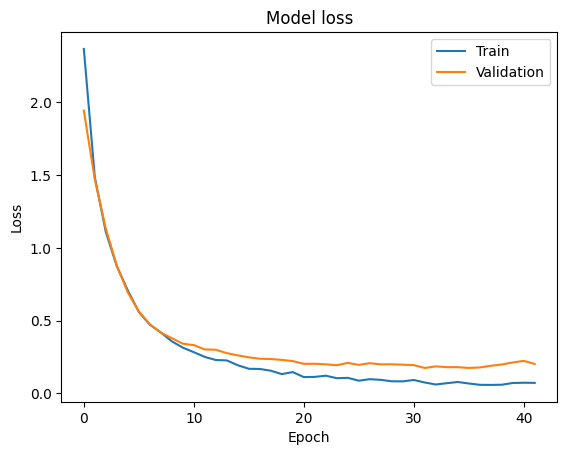

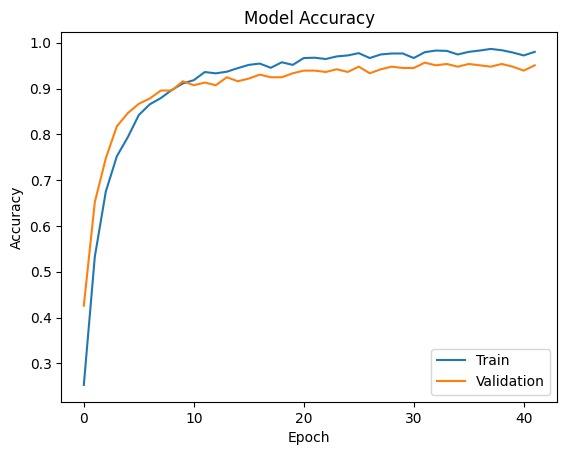

In [40]:
loss = model.evaluate(validation_ds)

# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot the accuracy of training and validation

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1/1 [==============================] - 1s 1s/step


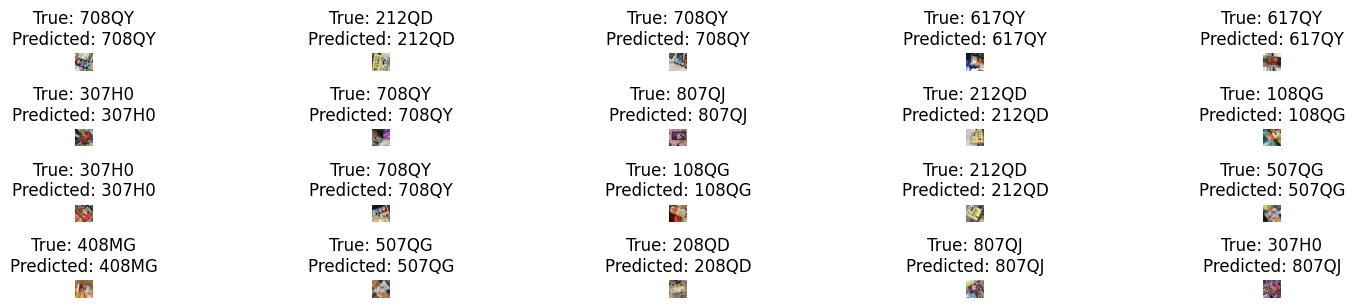

In [41]:
class_labels = list(test_ds.class_indices.keys())

# Predict on each image and plot results
num_images = 20
num_images_per_row = 5  # Set the number of images per row
num_rows =13

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(test_ds)
    predictions = model.predict(image)

    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]

            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()

In [102]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 圖像的路徑
img_path = '/content/drive/MyDrive/Model/test/807QJ/IMG_2802.JPG'

# `img` 是一個 PIL 的image的instance, 它的大小是224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` 是一個 float32 Numpy array, 它的 shape 是 (224, 224, 3)
x = image.img_to_array(img)

# 為了要成為網絡的input, 多增加一個維度來表示批次裡的圖像數量, 因為測試的圖像只有一個所以結果的shape是 (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# 進行圖像的預處理
x = preprocess_input(x)

In [103]:

# 進行預測
preds = model.predict(x)

# 解析預測結果
predicted_class = np.argmax(preds, axis=1)
print(f'Predicted class: {predicted_class}')

# 類別名稱
class_names = ['108QG', '117QG', '208Q', '212QD', '307Q0', '315QH', '408MG', '416HG', '507QG', '617QY', '708QY', '807QJ', '905TY']
print(f'Predicted class name: {class_names[predicted_class[0]]}')

1/1 [==============================] - 0s 52ms/step
Predicted class: [11]
Predicted class name: 807QJ


In [81]:
# 需再調整